In [1]:
import PIL
from PIL import Image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from tifffile import imread
from torchvision.transforms import functional as F
from typing import Tuple

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
class CustomPad(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        w, h = np.array(img).shape
        return F.pad(img, [(self.size - h) // 2 + 1, (self.size - w) // 2 + 1])

    def __repr__(self):
        return self.__class__.__name__ + "(size={})".format(self.size)

<IPython.core.display.Javascript object>

In [62]:
class CustomCenteredCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img, centroid: Tuple[int, int]):
        x, y = centroid
        fill = int(np.percentile(np.array(img), 1))
        img = transforms.Pad(self.size, fill=fill)(img)
        img = transforms.functional.crop(
            img, x + (self.size // 2), y + (self.size // 2), self.size, self.size
        )
        return img

    def __repr__(self):
        return self.__class__.__name__ + "(size={})".format(self.size)

<IPython.core.display.Javascript object>

In [4]:
def read_image(image_loc):
    image = imread(image_loc)
    if (image > 255).any():
        image_min = np.percentile(image, 0.1)
        image_max = np.percentile(image, 99.9)
        if image_max > 0:
            image = image - image_min
            image = image / image_max
        image = np.array(np.clip(image, 0, 1) * 255, dtype=np.uint8)
    pil_image = Image.fromarray(image)
    return pil_image

<IPython.core.display.Javascript object>

In [5]:
nuclei_img = read_image(
    "../../../data/experiments/image_preprocessing/full_pipeline/nuclei_images/41744/taoe005-u2os-72h-cp-a-au00044859_g05_s8_w1595a14fe-a32a-40dd-a343-f80eed50e307_illum_corrected_31.tif"
)
slide_img = read_image(
    "../../../data/experiments/image_preprocessing/full_pipeline/filtered/41744/taoe005-u2os-72h-cp-a-au00044859_g05_s8_w1595a14fe-a32a-40dd-a343-f80eed50e307_illum_corrected.tif"
)

<IPython.core.display.Javascript object>

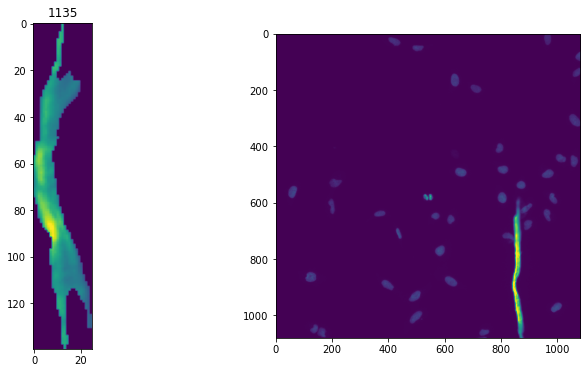

<IPython.core.display.Javascript object>

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=[12, 6])
ax = ax.flatten()
ax[0].imshow(np.array(nuclei_img))
ax[0].set_title((np.array(nuclei_img) > 0).sum())
ax[1].imshow(np.array(slide_img))

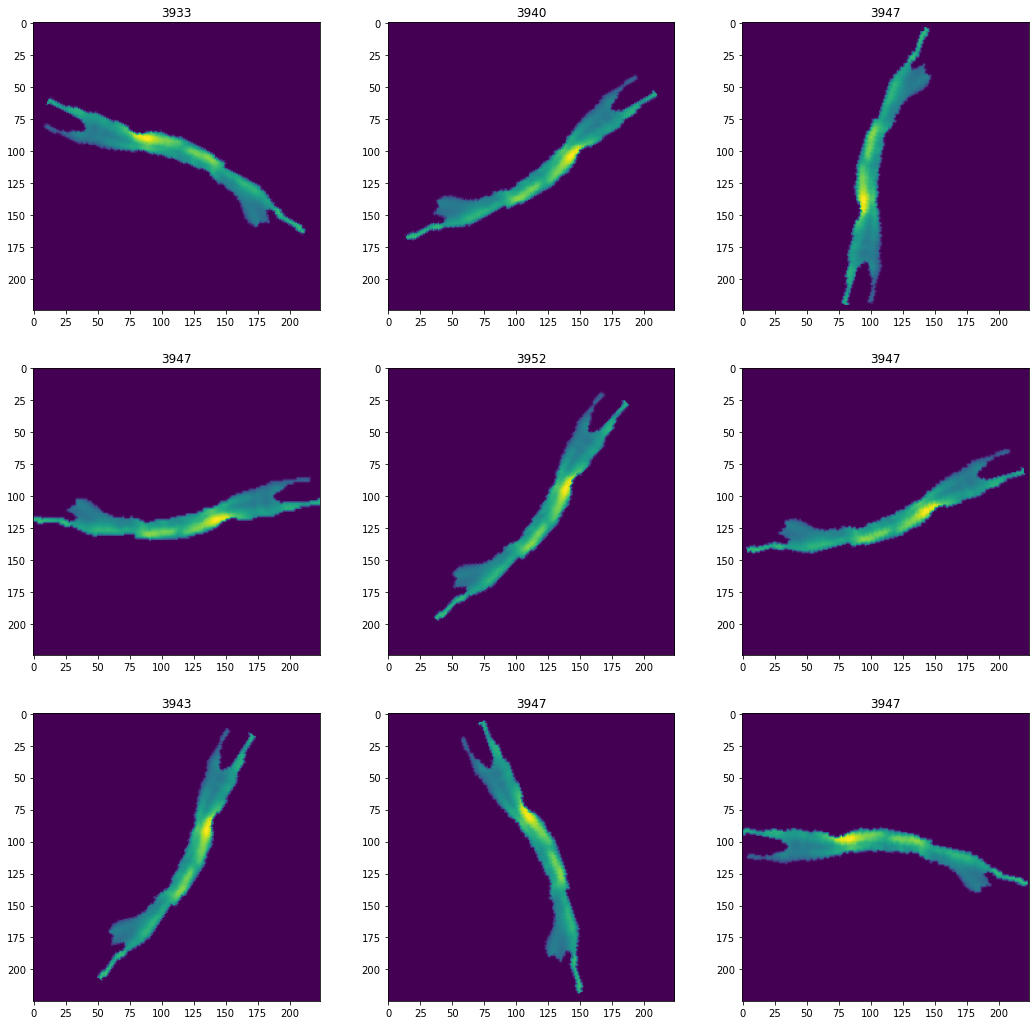

<IPython.core.display.Javascript object>

In [7]:
# Rotation
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[18, 18])
ax = ax.flatten()
for i in range(9):
    rotated_img = transforms.Compose(
        [
            CustomPad(128),
            transforms.Resize(224),
            transforms.RandomRotation(180, expand=False),
        ]
    )(nuclei_img)
    ax[i].imshow(np.array(rotated_img))
    ax[i].set_title((np.array(rotated_img) > 0).sum())

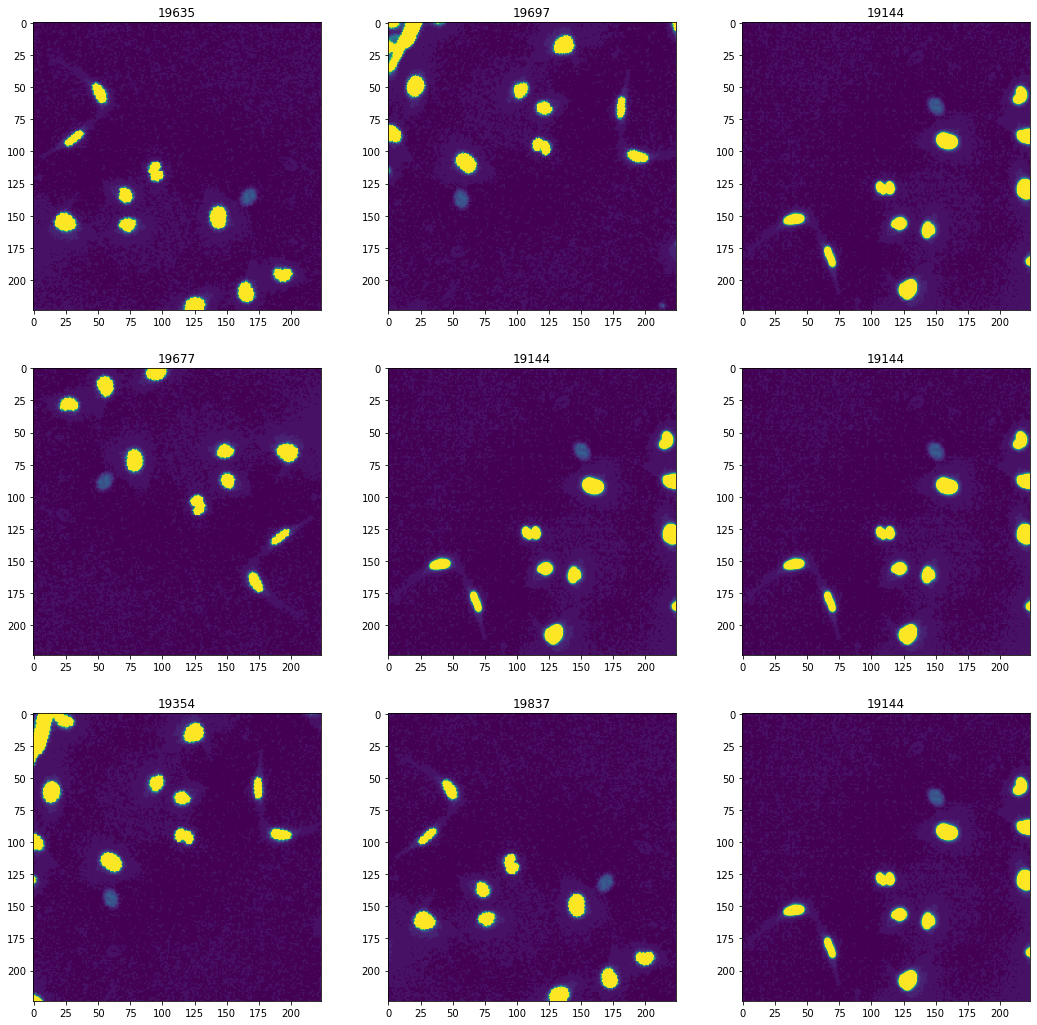

<IPython.core.display.Javascript object>

In [8]:
# Rotation
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[18, 18])
ax = ax.flatten()
for i in range(9):
    rotated_img = transforms.Compose(
        [
            transforms.Resize(448),
            transforms.RandomApply(
                [
                    transforms.RandomRotation(
                        180,
                        expand=False,
                        # interpolation=transforms.functional.InterpolationMode.BICUBIC,
                    )
                ]
            ),
            transforms.CenterCrop(224),
        ]
    )(slide_img)
    ax[i].imshow(np.array(rotated_img), vmin=0, vmax=20)
    ax[i].set_title((np.array(rotated_img) > 0).sum())

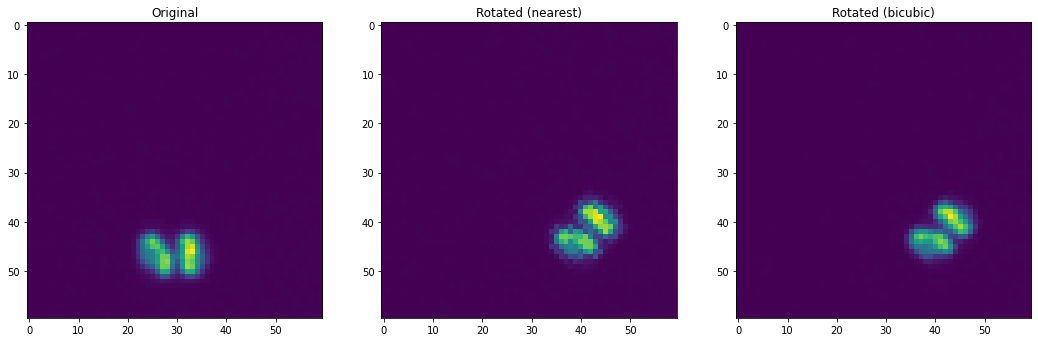

<IPython.core.display.Javascript object>

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[18, 6])
ax = ax.flatten()
original_img = transforms.Compose([transforms.Resize(448), transforms.CenterCrop(60)])(
    slide_img
)
ax[0].imshow(np.array(original_img))
ax[0].set_title("Original")
rot_img1 = transforms.Compose(
    [
        transforms.Resize(448),
        transforms.RandomRotation([45, 45]),
        transforms.CenterCrop(60),
    ]
)(slide_img)
ax[1].imshow(np.array(rot_img1))
ax[1].set_title("Rotated (nearest)")
rot_img2 = transforms.Compose(
    [
        transforms.Resize(448),
        transforms.RandomRotation(
            [45, 45], interpolation=transforms.functional.InterpolationMode.BICUBIC
        ),
        transforms.CenterCrop(60),
    ]
)(slide_img)
ax[2].imshow(np.array(rot_img2))
ax[2].set_title("Rotated (bicubic)")
plt.show()

In [43]:
from skimage.filters import threshold_otsu

<IPython.core.display.Javascript object>

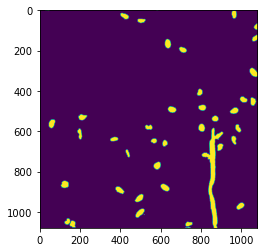

<IPython.core.display.Javascript object>

In [47]:
binary = np.array(slide_img) ** 0.5 > threshold_otsu(np.array(slide_img) ** 0.5)
plt.imshow(binary)


In [48]:
from skimage import measure

regions = measure.regionprops(measure.label(binary), np.array(slide_img))

<IPython.core.display.Javascript object>

In [51]:
len(regions)

43

<IPython.core.display.Javascript object>

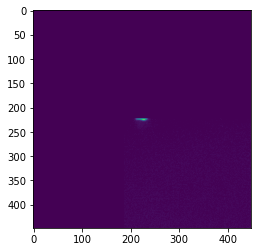

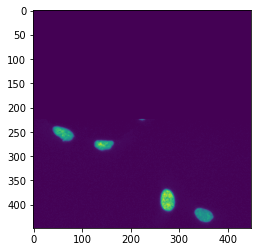

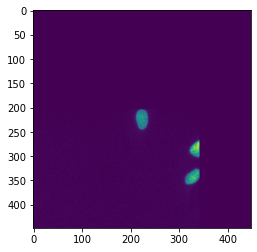

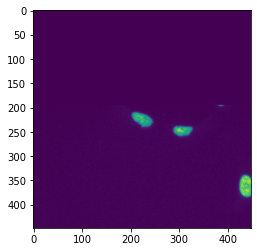

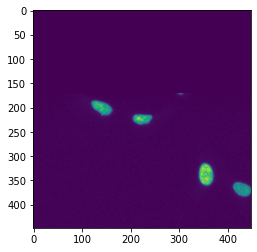

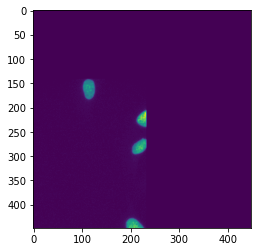

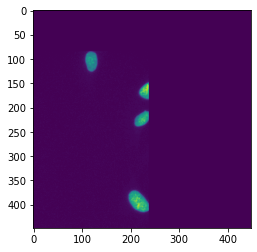

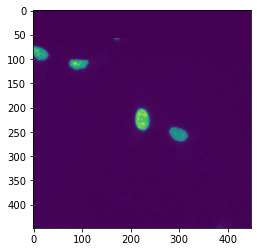

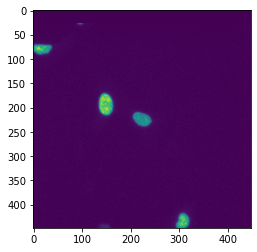

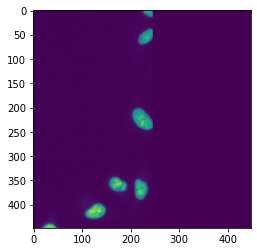

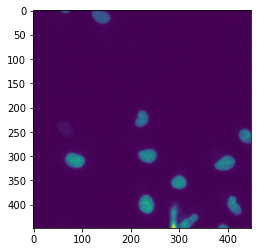

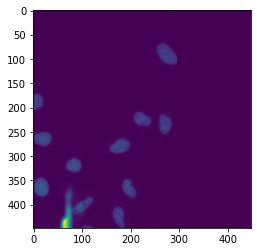

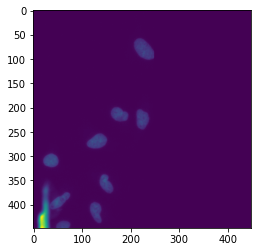

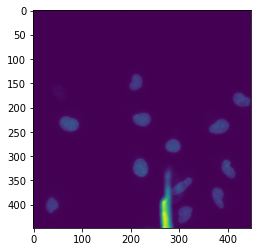

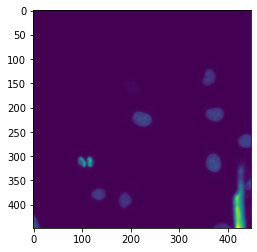

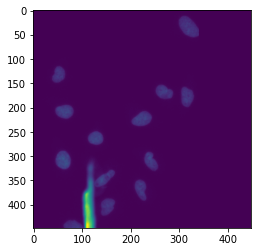

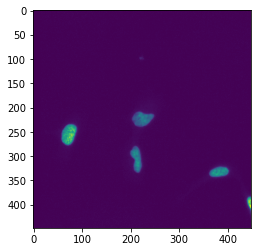

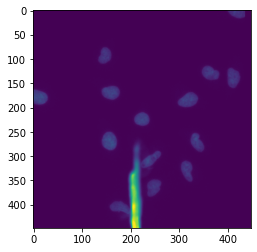

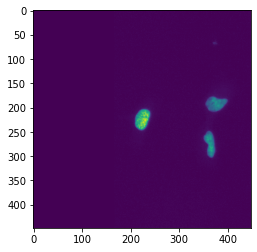

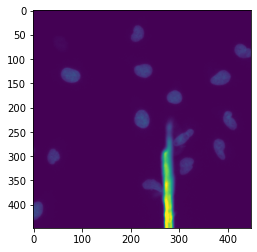

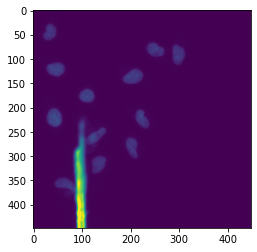

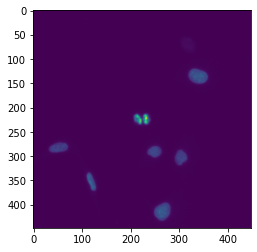

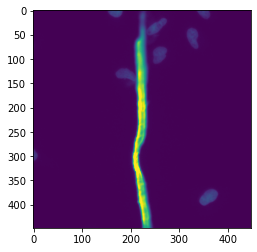

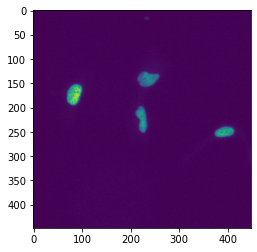

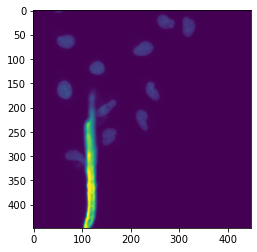

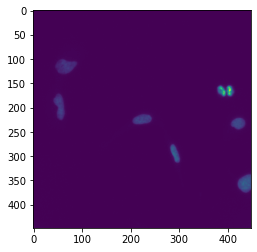

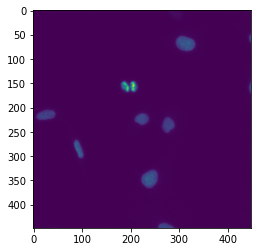

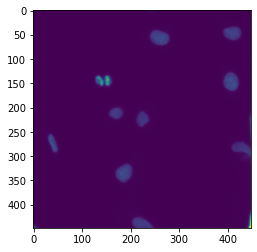

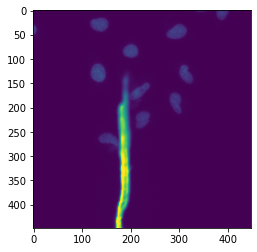

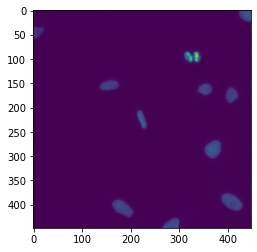

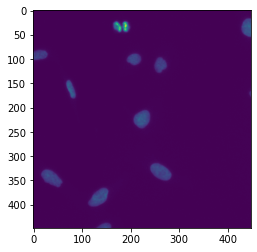

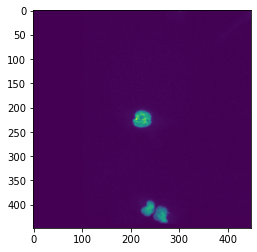

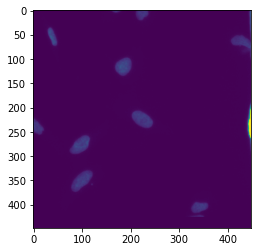

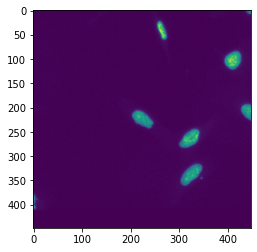

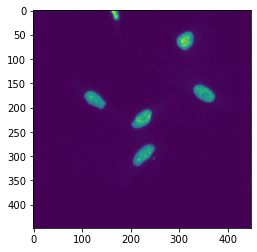

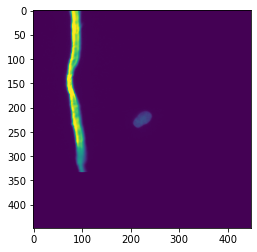

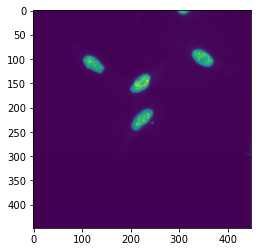

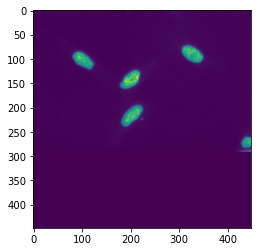

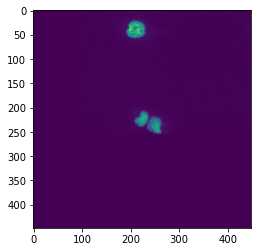

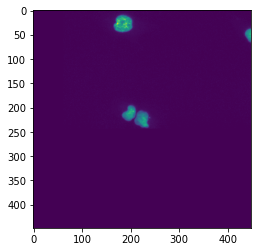

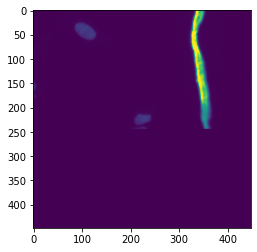

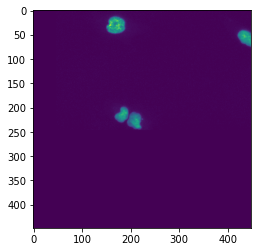

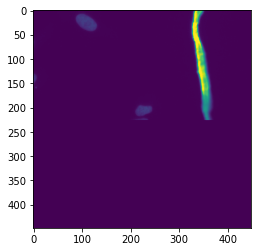

<IPython.core.display.Javascript object>

In [63]:
for region in regions:
    plt.imshow(CustomCenteredCrop(448)(slide_img, region.centroid))
    plt.show()

In [24]:
np.repeat(slide_img, 3)

ValueError: axes don't match array

<IPython.core.display.Javascript object>